# Spatial communication - cell level

## Read and preprocessing

In [1]:
import warnings
warnings.filterwarnings("ignore")
import scanpy as sc
import pandas as pd
import numpy as np
import SOAPy_st as sp

In [2]:
adata = sc.read_visium(path=r'C:\Users\Administrator.DESKTOP-MAL5PKV\Desktop\jsy-ST\A_230357',
                       count_file='filtered_feature_bc_matrix.h5'
                       )
annotation = pd.read_csv(r'C:\Users\Administrator.DESKTOP-MAL5PKV\Desktop\jsy-ST\Q2_TSF-high\A.csv',
                         header=0, index_col=0
                         )
lr_data = pd.read_csv(r'C:\Users\Administrator.DESKTOP-MAL5PKV\Desktop\Human-2020-Jin-LR-pairs.csv',
                      header=0, index_col=0
                      )

adata.obs['cluster'] = annotation.loc[adata.obs_names, 'TSF_type']

In [ ]:
adata.var_names_make_unique()
sc.pp.filter_genes(adata, min_counts=10)
sc.pp.filter_genes(adata, min_cells=2)
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

In [3]:
lr_pairs = sp.tl.lr_pairs(
    lr_data=lr_data,
    Annotation_key='annotation',
    ligand_key='ligand_symbol',
    receptor_key='receptor_symbol'
)
lr_pairs.get_complexes()

In [4]:
sp.tl.cell_level_communications(
    adata=adata,
    lr_pairs=lr_pairs,
    secretory_key='Secreted Signaling',
    contact_key='Cell-Cell Contact',
    secretory_radius=200,
    n_iters=1000,
)

sp.tl.cell_level_communications(
    adata=adata,
    lr_pairs=lr_pairs,
    species='receptor',
    secretory_key='Secreted Signaling',
    contact_key='Cell-Cell Contact',
    secretory_radius=200,
    n_iters=1000,
)

There are 806 cell-cell contact ligand-receptor pairs in sample
In contact mode, The average number of neighbors is 5.690730106644791
In contact mode, total of 0 spots have no neighbors


806 contact ligand-receptor pairs.: 100%|█████████████████████████████████████████████████████████ [ time left: 00:00 ]


Updated adata.uns[lr_summary]
There are 1199 secreted ligand-receptor pairs in sample
In secretory mode, The average number of neighbors is 211.77091878589007
In secretory mode, total of 0 spots have no neighbors


1199 secretory ligand-receptor pairs.: 100%|██████████████████████████████████████████████████████ [ time left: 00:00 ]


Updated adata.uns[lr_summary]
There are 806 cell-cell contact ligand-receptor pairs in sample
In contact mode, The average number of neighbors is 5.690730106644791
In contact mode, total of 0 spots have no neighbors


806 contact ligand-receptor pairs.: 100%|█████████████████████████████████████████████████████████ [ time left: 00:00 ]


Updated adata.uns[lr_summary]
There are 1199 secreted ligand-receptor pairs in sample
In secretory mode, The average number of neighbors is 211.77091878589007
In secretory mode, total of 0 spots have no neighbors


1199 secretory ligand-receptor pairs.: 100%|██████████████████████████████████████████████████████ [ time left: 00:00 ]


Updated adata.uns[lr_summary]


AnnData object with n_obs × n_vars = 4877 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'SOAPy'
    obsm: 'spatial'

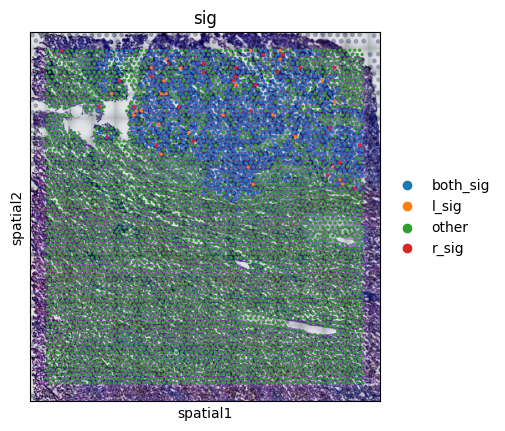

In [5]:
comm = adata.uns['SOAPy']['ligand_cell_comm_score']
ligand_cell_communication = pd.DataFrame(comm['contact_affinity']['p_vals'], index=adata.obs_names,
                                         columns=comm['contact_names'])
ligand_cell_communication['COL1A1:ITGA1&ITGB1'].tolist()

comm = adata.uns['SOAPy']['receptor_cell_comm_score']
receptor_cell_communication = pd.DataFrame(comm['contact_affinity']['p_vals'], index=adata.obs_names,
                                         columns=comm['contact_names'])

adata.obs['sig'] = 'other'
for index in adata.obs_names:
    ligand_sig = ligand_cell_communication.loc[index, 'COL1A1:ITGA1&ITGB1']
    receptor_sig = receptor_cell_communication.loc[index, 'COL1A1:ITGA1&ITGB1']
    if ligand_sig < 0.05 and receptor_sig < 0.05:
        adata.obs.loc[index, 'sig'] = 'both_sig'
        continue
    elif ligand_sig < 0.05:
        adata.obs.loc[index, 'sig'] = 'l_sig'
        continue
    elif receptor_sig < 0.05:
        adata.obs.loc[index, 'sig'] = 'r_sig'
        continue

sc.pl.spatial(adata, img_key="hires", color=["sig"])